In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

import plotly.graph_objects as go 
from plotly.subplots import make_subplots 

# Standardization ((X - X_mean)/X_std)
from sklearn.preprocessing import StandardScaler

# Importing models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split 

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Reading the data from mounted drive into our notebook.

In [ ]:
cardioVascularData = pd.read_csv('/content/drive/MyDrive/cardio_train.csv', delimiter = ';')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cardioVascularData.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
""" 
Dropping column ID to avoid redundancy.
"""
cardioVascularData.drop(columns=['id'], inplace=True)

Handling missing values: No missing values were found, thus no handling was required.

In [ ]:
"""
Checking if dataset contains missing values.
"""
for feature in cardioVascularData.columns:
  print("# of missing values in {}: {}".format(feature, cardioVascularData[feature].isnull().sum()))

# of missing values in age: 0
# of missing values in gender: 0
# of missing values in height: 0
# of missing values in weight: 0
# of missing values in ap_hi: 0
# of missing values in ap_lo: 0
# of missing values in cholesterol: 0
# of missing values in gluc: 0
# of missing values in smoke: 0
# of missing values in alco: 0
# of missing values in active: 0
# of missing values in cardio: 0


Class Imbalance: Checked for class imbalance, clearly the data is well balanced as there are 35021 instances for class 0 and 34979 instances for class 1.

In [ ]:
"""
Checking for imbalance in data.
"""
print("Checking class imbalance: \nClass 0 has {0} values. \nClass 1 has {1} values. \nPerfectly balanced data!!".format(cardioVascularData.cardio.value_counts()[0],
                                                                                                 cardioVascularData.cardio.value_counts()[1]))

Checking class imbalance: 
Class 0 has 35021 values. 
Class 1 has 34979 values. 
Perfectly balanced data!!


Checking for duplicates (identical rows) in data, before preprocessing.

In [ ]:
""" 
Checking if data has any duplicates present 
{duplicate values may harm the training process}.
""" 
if cardioVascularData.duplicated().sum() > 0:
    print('Duplicates rows prior to preprocessing are : {}'.format(
        cardioVascularData.duplicated().sum()))
else:
    print('Dataset contains no Duplicate Values')

Duplicates rows prior to preprocessing are : 24


In [ ]:
cardioVascularData.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(
    cardioVascularData.shape[0], cardioVascularData.shape[1]))

Total 69976 datapoints remaining with 12 features


Detecting outliers: On exploring our data we observed that there were some unusual values for features "ap_lo" and "ap_hi". So, we decided to use Boxplot to validate this intuition.

In [ ]:
"""
Checking features WEIGHT and HEIGHT for outliers since 
there are some large values.
"""
fig1 = go.Figure()

fig1.add_trace(go.Box(x = cardioVascularData['ap_hi'], name = 'Systolic', boxpoints = 'outliers'))
fig1.add_trace(go.Box(x = cardioVascularData['ap_lo'], name = 'Diastolic', boxpoints='outliers'))

fig1.update_layout(title_text = "Box Plot: Systolic Blood Pressure and Diastolic Blood Pressure.")
fig1.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Systolic Distribution", 
                                                    "Diastolic Distribution"))

trace0 = go.Histogram(x = cardioVascularData['ap_hi'], name = 'Systolic')
trace1 = go.Histogram(x = cardioVascularData['ap_lo'], name = 'Diastolic')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig.update_xaxes(title_text = "Systolic", row = 2, col = 1)
fig.update_yaxes(title_text =" Total Count", row = 1, col = 1)

fig.update_xaxes(title_text = "Diastolic", row = 2, col = 2)
fig.update_yaxes(title_text = "Total Count", row = 1, col = 2)

fig.update_layout(title_text = "Distribution of Blood Pressure", height = 700)
 
fig.show()

Paying attention to the plot above, we note that there are some really unusual values in "ap_hi" and "ap_lo". This motivated us to look into various guidelines for blood pressure (eg: range or blood pressure, unrealistic values).

To handle outliers, we looked into InterQuartile Range. A method that breaks down values into Quartiles and labels data points as outliers if they're above / below the desired range.

In [ ]:
# Handling outliers in "ap_hi" and "ap_lo":
ap_list = ["ap_hi", "ap_lo"]
boundary = pd.DataFrame(index = ["lower_bound", "upper_bound"])
for each in ap_list:
    Q1 = cardioVascularData[each].quantile(0.25)
    Q3 = cardioVascularData[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo
lower_bound,90.0,65.0
upper_bound,170.0,105.0


Below, we filter out blood pressure values based on a few medical guidelines that we discovered on the Internet. 

In [ ]:
ap_hi_filter = (cardioVascularData["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (cardioVascularData["ap_lo"] > boundary["ap_lo"][1]) 

outlier_filter = (ap_hi_filter | ap_lo_filter)

After reading articles on cdc, healthline and other healthcare websites we learnt that if values for both said features (above) is higher than some threshold, the patient should bee rushed to emergency as such values would not be present in a normal day situation. These values are 250 for Systolic and 200 for Diastolic. Any values above these values were discarded below.

In [ ]:
out_filter = (cardioVascularData["ap_hi"] > 250) | (cardioVascularData["ap_lo"] > 200)
print("There is {} outlier".format(cardioVascularData[out_filter]["cardio"].count(), cardioVascularData[out_filter]["cardio"].count()))

There is 993 outlier


In [ ]:
cleanData = cardioVascularData[~out_filter]
cleanData.shape

(68983, 12)

Now that we elminated outliers, we wanted to switch our attention to feature AGE. In this dataset, AGE was recorded in days. This could lead to a lot of potential issues as the model might perform bad on large values where some have some large difference (issue of scale). Hence, we decided to convert AGE in days to AGE in years.

In [ ]:
cleanData['age'] = cleanData['age'].div(365).apply(lambda x: int(x))

In [ ]:
cleanData = cleanData.reset_index()

In [ ]:
cleanData = cleanData.drop('index', axis = 1)

Checking for duplicates after handling outliers.
There are no duplicates after handling outliers in the said features.

In [ ]:
cleanData.duplicated().sum()

3184

Feature Engineering: Since we had features like weight and height, we thought of using the said to create another feature "BMI" - Body Mass Index. We wanted to observe the effect BMI might have on our models.

In [ ]:
cleanData['BMI'] = cleanData['weight'] / (cleanData['height']/100)**2

In [ ]:
cleanData.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [ ]:
cleanData.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleanData.shape[0], cleanData.shape[1]))

Total 65799 datapoints remaining with 13 features


In [ ]:
print('Before preprocessing {}\nAfter preprocessing {}'.format(cardioVascularData.shape, cleanData.shape))

Before preprocessing (69976, 12)
After preprocessing (65799, 13)


In [ ]:
"""
Visualizing categorical variable that have been encoded already.
"""
fig = make_subplots(rows=2, cols=2, subplot_titles=(""))

trace0 = go.Histogram(x = cleanData['cholesterol'], name = 'Cholesterol')
trace1 = go.Histogram(x = cleanData['smoke'], name = 'Smoke')
trace2 = go.Histogram(x = cleanData['alco'], name = 'Drink')
trace3 = go.Histogram(x = cleanData['active'], name = 'Active')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_xaxes(title_text = "Cholestrol Level", row = 1, col = 1)
fig.update_yaxes(title_text =" Total Count", row = 1, col = 1)

fig.update_xaxes(title_text = "Smoking History", row = 1, col = 2)
fig.update_yaxes(title_text = "Total Count", row = 1, col = 2)

fig.update_xaxes(title_text = "Alcohol Intake", row = 2, col = 1)
fig.update_yaxes(title_text =" Total Count", row = 1, col = 1)

fig.update_xaxes(title_text = "Physically Active", row = 2, col = 2)
fig.update_yaxes(title_text = "Total Count", row = 1, col = 2)

fig.update_layout(title_text = "Distribution of categorical variables that were pre-encoded and provided in the dataset.", height = 700)
 
fig.show()

In [ ]:
fig = go.Figure(data=[go.Bar(x = cleanData[cleanData['cardio'] == 0]['age'].value_counts().index.to_list(), 
                             y = cleanData[cleanData['cardio'] == 0]['age'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleanData[cleanData['cardio'] == 1]['age'].value_counts().index.to_list(), 
                             y = cleanData[cleanData['cardio'] == 1]['age'].value_counts().values, name = 'CVD')])

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Age groups grouped by Target Value", 
        yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,),  
        xaxis=dict(title='Age',
        titlefont_size=16,
        tickfont_size=14))
fig.show()

From the graph above ^ we observe that there is a gradual increase in someone being more prone to Cardiovascular Disease with increase in Age. People till the age of 53 have reported lesser CVD positive cases, but as you grow older there is a higher chance you might be diagnosed for CVD.

In [ ]:
fig = go.Figure(data=[go.Bar(x = cleanData[cleanData['cardio'] == 0]['smoke'].value_counts().index.to_list(), y = cleanData[cleanData['cardio'] == 0]['smoke'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleanData[cleanData['cardio'] == 1]['smoke'].value_counts().index.to_list(), y = cleanData[cleanData['cardio'] == 1]['smoke'].value_counts().values, name = 'CVD')])

fig.update_layout(barmode='group', xaxis_tickangle = 0, title_text="Distribution of Age groups grouped by Target Value", 
        yaxis = dict(
        title = 'Total Count',
        titlefont_size = 16,
        tickfont_size = 14,),  
        xaxis = dict(title = 'Smoke',
        titlefont_size = 16,
        tickfont_size = 14))
fig.show()

In [ ]:
fig = go.Figure(data=[go.Bar(x = cleanData[cleanData['cardio'] == 0]['active'].value_counts().index.to_list(), 
                             y = cleanData[cleanData['cardio'] == 0]['active'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleanData[cleanData['cardio'] == 1]['active'].value_counts().index.to_list(), 
                             y = cleanData[cleanData['cardio'] == 1]['active'].value_counts().values, name = 'CVD')])

fig.update_layout(barmode='group', xaxis_tickangle= 0, title_text="Distribution of people who are physically active grouped by Target Value", 
        yaxis = dict(
        title = 'Total Count',
        titlefont_size = 16,
        tickfont_size = 14),  
        xaxis = dict(title = 'Physically Active',
        titlefont_size = 16,
        tickfont_size = 14))
fig.show()

In [ ]:
fig = go.Figure(data=[go.Bar(x = cleanData[cleanData['cardio'] == 0]['gender'].value_counts().index.to_list(), y = cleanData[cleanData['cardio'] == 0]['gender'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleanData[cleanData['cardio'] == 1]['gender'].value_counts().index.to_list(), y = cleanData[cleanData['cardio'] == 1]['gender'].value_counts().values, name = 'CVD')])

fig.update_layout(barmode='group', xaxis_tickangle = 0, title_text="Distribution of Gender grouped by Target Variable", 
        yaxis = dict(
        title = 'Total Count',
        titlefont_size=16,
        tickfont_size = 14),  
        xaxis = dict(title = 'Gender',
        titlefont_size = 16,
        tickfont_size = 14))
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Height Distribution for non CVD Population", "Height Distribution for CVD Population", "Weight Distribution for non CVD Population", "Weight Distribution for CVD Population"))

trace0 = go.Histogram(x = (cleanData[cleanData['cardio'] == 0]['height']), name = 'Non CVD')
trace1 = go.Histogram(x = (cleanData[cleanData['cardio'] == 1]['height']), name = 'CVD')

trace2 = go.Histogram(x = (cleanData[cleanData['cardio'] == 0]['weight']), name = 'Non CVD')
trace3 = go.Histogram(x = (cleanData[cleanData['cardio'] == 1]['weight']), name = 'CVD')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_xaxes(title_text = "Height", row = 1, col = 1)
fig.update_yaxes(title_text = "Total Count", row = 1, col = 1)

fig.update_xaxes(title_text="Height", row=1, col=2)
fig.update_yaxes(title_text="Total Count", row=1, col=2)

fig.update_xaxes(title_text="Weight", row=2, col=1)
fig.update_yaxes(title_text="Total Count", row=2, col=1)

fig.update_xaxes(title_text="Weight", row=2, col=2)
fig.update_yaxes(title_text="Total Count", row=2, col=2)

fig.show()

In [ ]:
fig = go.Figure([go.Pie(labels = ['CVD Negative', 'CVD Positive'],values = cleanData['cardio'].value_counts().values)])
fig.update_layout(title_text = "Pie chart of Target Variable", template = "plotly_white")
fig.data[0].marker.line.color = 'rgb(255, 255, 255)'
fig.data[0].marker.line.width = 3
fig.update_traces(hole = .3)
fig.show()
print("From the plot above, we can observe that the data is balanced.")

From the plot above, we can observe that the data is balanced.


In [ ]:
fig = make_subplots(rows = 2, cols = 3, 
                    subplot_titles = ("Alcohol Distribution", "Gender Distribution", "Choslesterol Distribution", "Glucose Distribution", "Smoking Distribution", "Activity Distribution"), 
                    specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels = ['Non Alcoholic', 'Alcoholic'], values = cleanData['alco'].value_counts().values, name = 'Alcohol Status'), 1, 1)
fig.add_trace(go.Pie(labels = ['Female', 'Male'], values = cleanData['gender'].value_counts().values, name = 'Gender Status'), 1, 2)

fig.add_trace(go.Pie(labels = ['Normal', 'Above Normal', 'Well Above Normal'], values = cleanData['cholesterol'].value_counts().values, name = 'Cholesterol Level Status'), 1, 3)
fig.add_trace(go.Pie(labels = ['Normal', 'Above Normal', 'Well Above Normal'], values = cleanData['gluc'].value_counts().values, name = 'Glucose Level Status'), 2, 1)

fig.add_trace(go.Pie(labels = ['Non Smoker', 'Smoker'],values = cleanData['smoke'].value_counts().values, name = 'Smoking Status'), 2, 2)
fig.add_trace(go.Pie(labels = ['Not Involved in Physical Activites', 'Involved in Physical Activites'], values = cleanData['active'].value_counts().values, name = 'Fitness Status'), 2, 3)

fig.update_traces(hole = .3)
fig.update_layout(title_text="Distribution of values in Features.")

fig.show()

In [ ]:
cleanData.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


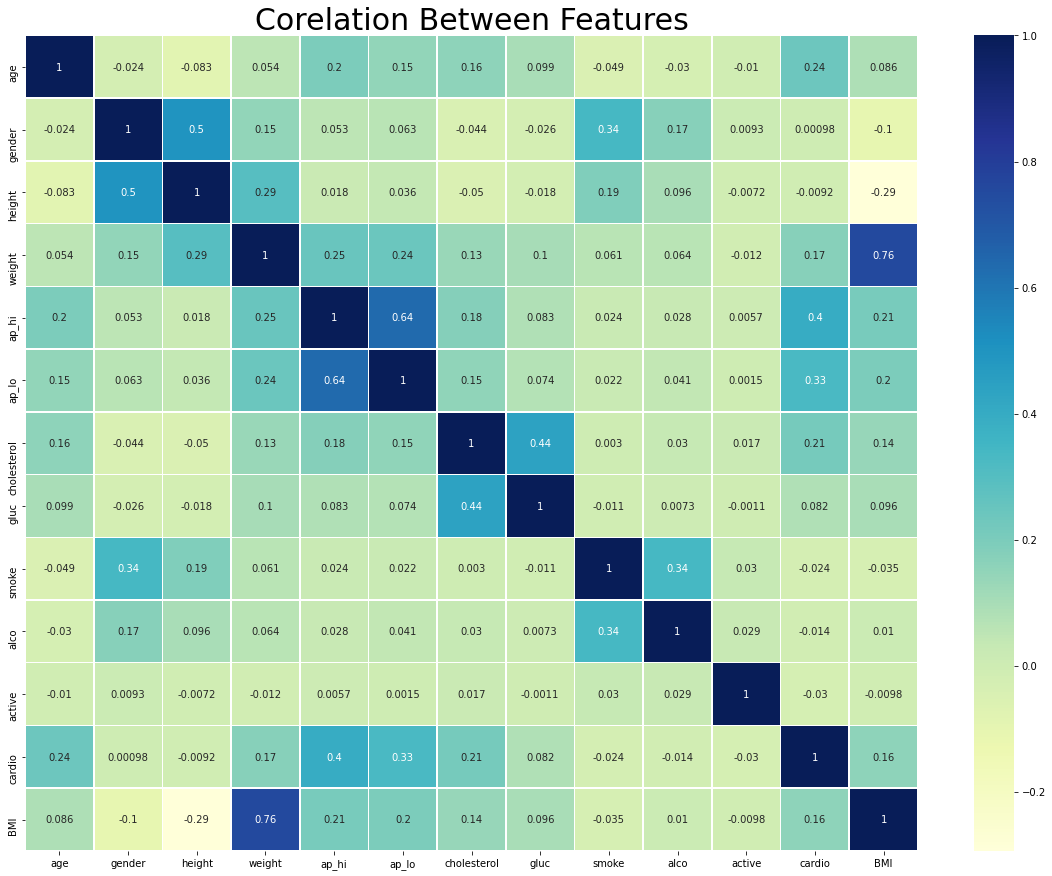

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(cleanData.corr(), annot = True, linewidths = .5, cmap = "YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

In [ ]:
# X = cleanData.drop(['cardio', 'bmi', 'weight', 'gender', 'smoke', 'alco', 'active'], axis =1)
Y = cleanData['cardio']
X = cleanData.drop(['cardio'], axis =1)
# , 'gender', 'smoke', 'alco', 'active'

In [ ]:
X

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...
68977,57,1,165,80.0,150,80,1,1,0,0,1,29.384757
68979,61,1,158,126.0,140,90,2,2,0,0,1,50.472681
68980,52,2,183,105.0,180,90,3,1,0,1,0,31.353579
68981,61,1,163,72.0,135,80,1,2,0,0,0,27.099251


In [ ]:
"""
Standardization preformed before splitting the data into test and train. Common mistake?

Solution: Standardizing data once the data has been split into test and train.
OBSERVE: Compare results - are there any improvements, is the performance same or does it decrease?
Try looking into normalization at the same time. Does it 
""" 
# scaler = StandardScaler()
# standard_X = scaler.fit_transform(X)

'\nStandardization preformed before splitting the data into test and train. Common mistake?\n\nSolution: Standardizing data once the data has been split into test and train.\nOBSERVE: Compare results - are there any improvements, is the performance same or does it decrease?\nTry looking into normalization at the same time. Does it \n'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52639, 12) (13160, 12) (52639,) (13160,)


In [ ]:
"""
Standardize data after splitting the data into test and train:
"""

'\nStandardize data after splitting the data into test and train:\n'

In [ ]:
dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()
log = LogisticRegression()
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Logistic Regression": log,
          "Naive bayes" : naive}
scores= { }

for key, value in models.items():    
    model = value
    model.fit(X_train, y_train)
    scores[key] = model.score(X_test, y_test)

In [ ]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0, inplace=True)
scores_frame

,Accuracy Score
Decision tree,0.616033
Random forest,0.687614
Naive bayes,0.696429
KNN,0.713374
Logistic Regression,0.714286
SVM,0.716337


The results we obtained above are on unscaled raw data. Let's compare model performance on scaled data.

In [ ]:
X_train_standard = X_train.copy()
X_test_standard = X_test.copy()

In [ ]:
numeric_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']

In [ ]:
for i in numeric_columns:
  scale = StandardScaler().fit(X_train_standard[[i]])
  X_train_standard[i] = scale.transform(X_train_standard[[i]])
  X_test_standard[i] = scale.transform(X_test_standard[[i]])

In [ ]:
dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()
log = LogisticRegression()
models_standard = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Logistic Regression": log,
          "Naive bayes" : naive}
scores_standard = { }

for key, value in models_standard.items():    
    model = value
    model.fit(X_train_standard, y_train)
    scores_standard[key] = model.score(X_test_standard, y_test)

In [ ]:
scores_frame_standard = pd.DataFrame(scores_standard, index=["Accuracy Score"]).T
scores_frame_standard.sort_values(by=["Accuracy Score"], axis=0, inplace=True)
scores_frame_standard

,Accuracy Score
Decision tree,0.613298
Random forest,0.686398
Naive bayes,0.696429
Logistic Regression,0.715805
KNN,0.723632
SVM,0.723632


In [ ]:
combined_scores = pd.DataFrame()

In [ ]:
"""
Combined dataframe of scores produced on unscaled data and scaled data.
"""
combined_scores['Standard data scores'] = scores_frame_standard['Accuracy Score']
combined_scores['Raw data scores'] = scores_frame['Accuracy Score']
combined_scores

,Raw data scores,Standard data scores
Decision tree,0.616033,0.613298
Random forest,0.687614,0.686398
Naive bayes,0.696429,0.696429
Logistic Regression,0.714286,0.715805
KNN,0.713374,0.723632
SVM,0.716337,0.723632


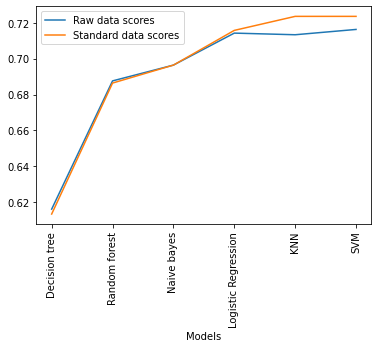

In [ ]:
"""
Generating a line plot to visually note if there is a change in scores after standardization of data.
"""
plt.plot(combined_scores)
plt.xticks(rotation = 'vertical')
plt.xlabel('Models')
plt.legend(combined_scores.columns)

The above graph is a line plot displaying scores for the 6 methods mentioned above. On observing the graph we see that there is a sudden increase in model score for Logistic Regression, KNN and Support Vector Machines. It is also evident that Decision Trees do not perform well on standardized data. 

Hyperparameter tuning with 10 fold cross validation.

In [ ]:
random_forest = GridSearchCV(estimator = RandomForestClassifier(), param_grid = {'n_estimators': [100, 300]}, cv = 5).fit(X_train_standard, y_train)
random_forest.fit(X_train_standard, y_train)
acc_random_forest = round(random_forest.score(X_train_standard, y_train) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

98.36 {'n_estimators': 300}


GridsearchCV is ran on a range of parameters to find the optimal parameters which give the highest train accuracy. 10 fold cross validation is used to prevent overfitting. For Random Forest, we acheive best results when the number of estimators are equal to 300.

In [ ]:
acc_test_random_forest = round(random_forest.score(X_test_standard, y_test) * 100, 2)
acc_test_random_forest

69.03

There is a definite improvement in the prediction score on the testing dataset after hyperparameter tuning.

In [ ]:
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [50, 150]}, cv=10).fit(X_train_standard, y_train)
acc_knn = round(knn.score(X_train_standard, y_train) * 100, 2)
print(acc_knn, knn.best_params_)

73.13 {'n_neighbors': 150}


In [ ]:
acc_test_knn = round(knn.score(X_test_standard, y_test) * 100, 2)
acc_test_knn

72.19

The KNN algorithm is ran through a multitude of 'n_neighbors' values to determine the best one.

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Error Rate')

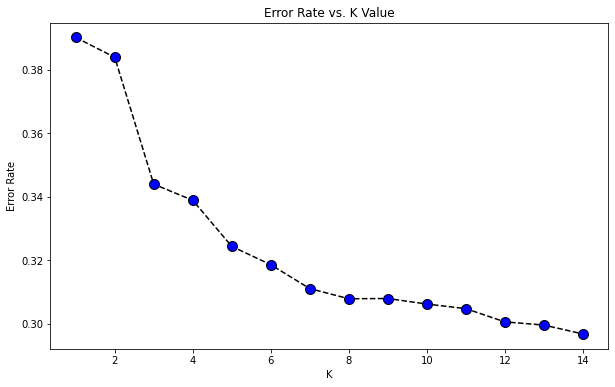

In [ ]:
error_rate = []

for i in range(1,15):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,15),error_rate,color='black', linestyle='dashed', marker='o',
         markerfacecolor = 'blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

As training process, we wanted to observe how different values of k in KNN would affect our score, which is why clearly noted above. On a range of 1-15, ideal k value is 14. 

Since our problem statement revolves around healthcare, False Negatives are more important for us than accuracy score. We do not want to put a patient in a situation where we predict that they do not have CVD, but in fact they might be very much prone to CVD. This motivated us to look at Precision and Recall for a better comparison of models.

In [ ]:
"""
Precision and Recall for KNN - Standardized data.
"""
Y_hat = knn.predict(X_test_standard)
print(classification_report(y_test, Y_hat))

print('True Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][0]))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73      6394
           1       0.77      0.66      0.71      6766

    accuracy                           0.72     13160
   macro avg       0.73      0.73      0.72     13160
weighted avg       0.73      0.72      0.72     13160

True Positive Cases : 4498
True Negative Cases : 5025
False Positive Cases : 1369
False Negative Cases : 2268


In [ ]:
"""
Precision and Recall for Logistic Regression - Standardized data.
"""
Y_hat = log.predict(X_test_standard)
print(classification_report(y_test, Y_hat))

print('True Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][0]))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      6394
           1       0.75      0.68      0.71      6766

    accuracy                           0.72     13160
   macro avg       0.72      0.72      0.72     13160
weighted avg       0.72      0.72      0.72     13160

True Positive Cases : 4585
True Negative Cases : 4835
False Positive Cases : 1559
False Negative Cases : 2181


In [ ]:
"""
Precision and Recall for SVM - Standardized data.
"""
Y_hat = svc.predict(X_test_standard)
print(classification_report(y_test, Y_hat))

print('True Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][0]))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      6394
           1       0.76      0.68      0.72      6766

    accuracy                           0.72     13160
   macro avg       0.73      0.73      0.72     13160
weighted avg       0.73      0.72      0.72     13160

True Positive Cases : 4575
True Negative Cases : 4948
False Positive Cases : 1446
False Negative Cases : 2191
